In [22]:
from os import path, makedirs, walk, listdir, remove
import pandas as pd
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Rescaling, Dropout, RandomFlip, RandomRotation, RandomZoom
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping
from keras import Model
from random import choice

In [35]:
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = 'dataset'
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')

#Hyperparameters
OPTIMIZER = Adam
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy')]
EPOCHS = 50
FOLDS =5
BATCH_SIZE = 32
VERBOSE = 2
REGULARIZER='l2'
INPUT_SHAPE = (256,256,1)

In [4]:
def categorise_images(a_dataset_name):
    #creates a directory structure  like: images/
    #                                       class0/*.jpg
    #                                       class1/*.jpg
    #and copies the images into either leaf directory depending on their class label
    #this puts the data into a format that keras can load into a dataset

    fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, a_dataset_name,CLASS_DIRECTORY_NAMES[0])
    print('fracture_directory', fracture_directory)
    no_fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS,a_dataset_name,CLASS_DIRECTORY_NAMES[-1])
    print('no_fracture_directory', no_fracture_directory)

    if path.exists(fracture_directory) == False:  
        makedirs(fracture_directory) 
    if path.exists(no_fracture_directory) == False:  
        makedirs(no_fracture_directory) 

    #read labels into pandas df
    csv_filepath = path.join(DATASET_DIRECTORY, a_dataset_name, 'labels/labels.csv')
    print('csv_filepath', csv_filepath)
    df = pd.read_csv(path.join(csv_filepath))
    df = df.set_index('filename')

    #walk through files and copy file to relevant directory
    images_dir = path.join(DATASET_DIRECTORY,a_dataset_name,'images')
    print('images_dir', images_dir)
    filenames = []
    for (dirpath, dirnames, filenames) in walk(images_dir):
        filenames.extend(filenames)
 
    for filename in filenames:
        #ignore mac os system file
        if filename.endswith('.DS_Store'):
            pass
        elif df.loc[filename]['target'] == 1:
            destination = path.join(fracture_directory, filename)
        else:
            destination = path.join(no_fracture_directory, filename)
        source = path.join(images_dir, filename)
        copyfile(source, destination)

In [14]:
for dataset_name in DATASET_NAMES:
    categorise_images(dataset_name)

fracture_directory dataset/categorised_images/train/class_fracture
no_fracture_directory dataset/categorised_images/train/class_no_fracture
csv_filepath dataset/train/labels/labels.csv
images_dir dataset/train/images
fracture_directory dataset/categorised_images/valid/class_fracture
no_fracture_directory dataset/categorised_images/valid/class_no_fracture
csv_filepath dataset/valid/labels/labels.csv
images_dir dataset/valid/images
fracture_directory dataset/categorised_images/test/class_fracture
no_fracture_directory dataset/categorised_images/test/class_no_fracture
csv_filepath dataset/test/labels/labels.csv
images_dir dataset/test/images


In [3]:
def find_and_remove_non_jpg_files(a_folder_path):
    #removes any non-jpg files in the provided directory
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = path.join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [4]:
#Check for any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        folder_path = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name,class_dir_name)
        print('checking folder: '+folder_path)
        find_and_remove_non_jpg_files(folder_path)
        folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: dataset/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_no_fracture
Deleted 0 files.
checked 6 folders


In [24]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory= path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [25]:
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')

Found 3630 files belonging to 2 classes.
Found 169 files belonging to 2 classes.
Found 348 files belonging to 2 classes.


In [26]:
combined_train_ds = train_ds.concatenate(valid_ds)

In [28]:
training_images = []
training_labels = []
for images, labels in combined_train_ds.as_numpy_iterator():
    training_images.extend(images)
    training_labels.extend(labels)
training_images = np.array(training_images).astype('float32')/255
training_labels = np.array(training_labels).astype('int')
print(training_images.shape)
print(training_labels.shape)

2024-03-19 11:03:29.511605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(3978, 256, 256, 1)
(3978, 1)


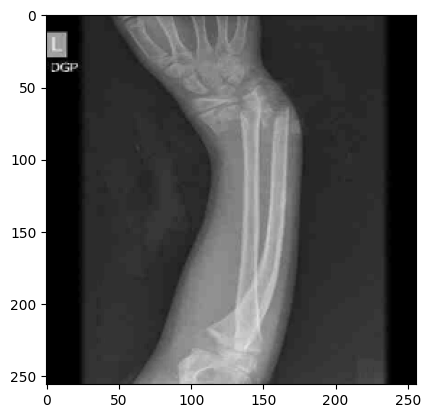

In [29]:
random_training_image = choice(training_images)
plt.imshow(random_training_image, cmap='gray')
plt.show()

In [30]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

In [12]:
def plot_augmented_images(original_image, augmented_image):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[1].imshow(augmented_image)
    ax[1].set_title('Augmented Image')
    plt.show()

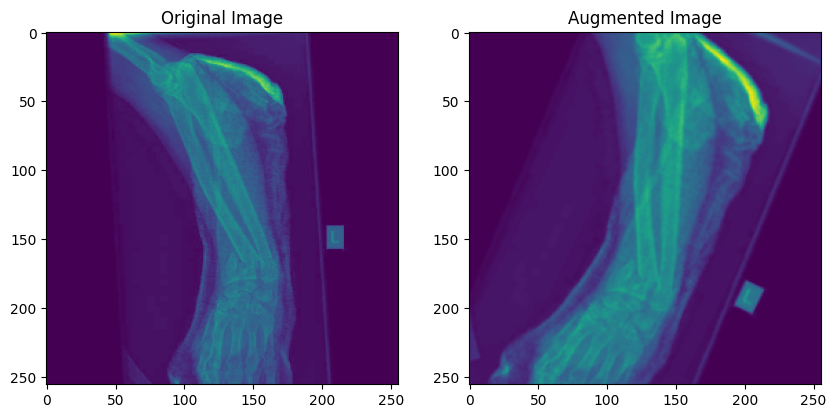

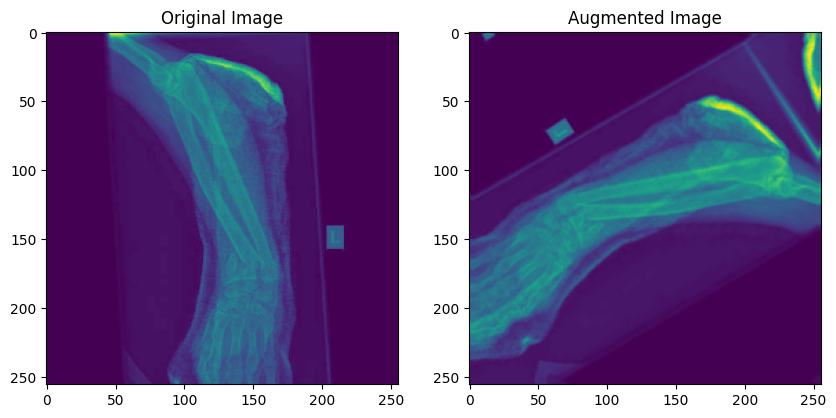

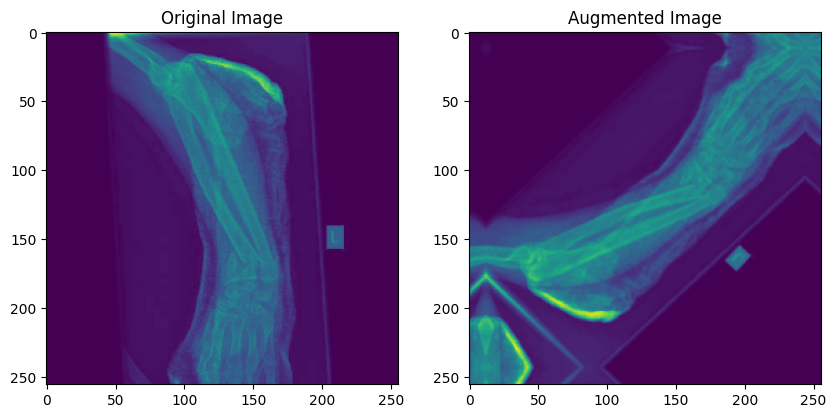

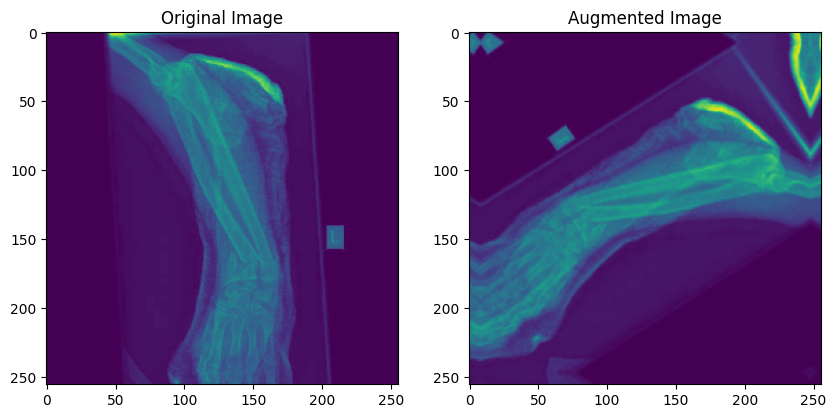

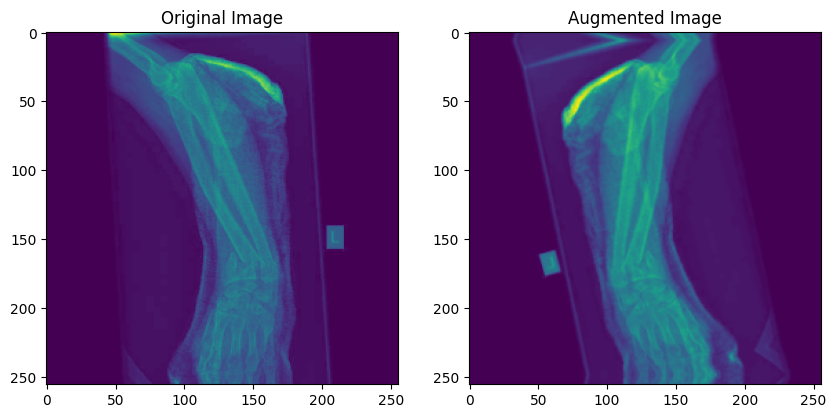

In [13]:
for i in range(5):
    augmented_image = data_augmentation(random_training_image)
    plot_augmented_images(random_training_image, augmented_image)

In [31]:
def create_model():
    inputs = Input(shape=(INPUT_SHAPE))
    #x = Rescaling(1./255)(x)
    x = data_augmentation(inputs)
    x = Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [34]:
create_model().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,785 (3.87 MB)

 Trainable params: 1,014,785 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def train_model(X_train, y_train, X_valid, y_valid):
    
    callbacks = [EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]
    
    model = create_model()
    
    model.compile(optimizer=OPTIMIZER(),
              loss=LOSS_FUNCTION(),
              metrics=METRICS)
    
    model_history = model.fit(X_train, y_train,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid, y_valid),
                              verbose=VERBOSE,
                              callbacks=callbacks)
    clear_session()

    return (model, model_history)

In [37]:
folds = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
folds.get_n_splits(training_images)
model_histories = []
validation_scores = []
for fold_index, (train_index, valid_index) in enumerate(folds.split(training_images)):
    X_train, X_valid = training_images[train_index], training_images[valid_index]
    y_train, y_valid = training_labels[train_index], training_labels[valid_index]
    print('Training model for fold:', fold_index + 1)
    model, model_history = train_model(X_train, y_train, X_valid, y_valid)
    model_histories.append(model_history)
    validation_score = model.evaluate(X_valid, y_valid)
    validation_scores.append(validation_score)

[print('validation_score for fold number ', str(index+1), ':' , str(validation_score)) for index, validation_score in enumerate(validation_scores)]

Training model for fold: 1
Epoch 1/50
100/100 - 13s - 127ms/step - accuracy: 0.5016 - loss: 0.6939 - val_accuracy: 0.5088 - val_loss: 0.6930
Epoch 2/50
100/100 - 11s - 110ms/step - accuracy: 0.4915 - loss: 0.6935 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 3/50
100/100 - 11s - 107ms/step - accuracy: 0.4874 - loss: 0.6932 - val_accuracy: 0.5088 - val_loss: 0.6931
Epoch 4/50
100/100 - 11s - 106ms/step - accuracy: 0.4881 - loss: 0.6932 - val_accuracy: 0.5088 - val_loss: 0.6931
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5176 - loss: 0.6929
Training model for fold: 2
Epoch 1/50
100/100 - 12s - 121ms/step - accuracy: 0.5058 - loss: 0.6939 - val_accuracy: 0.4975 - val_loss: 0.6930
Epoch 2/50
100/100 - 10s - 105ms/step - accuracy: 0.4906 - loss: 0.6934 - val_accuracy: 0.4975 - val_loss: 0.6932
Epoch 3/50
100/100 - 11s - 107ms/step - accuracy: 0.4928 - loss: 0.6932 - val_accuracy: 0.5025 - val_loss: 0.6931
Epoch 4/50
100/100 - 10s - 105ms/step - accuracy: 0.4972 - loss: 0.6932 - 

[None, None, None, None, None]

In [38]:
model_histories[2].history

{'accuracy': [0.4954751133918762,
  0.4937146306037903,
  0.502514123916626,
  0.5065996050834656,
  0.5062853693962097],
 'loss': [0.6955668926239014,
  0.6916424632072449,
  0.6939049363136292,
  0.6928449273109436,
  0.693696916103363],
 'val_accuracy': [0.4987437129020691,
  0.5188442468643188,
  0.4987437129020691,
  0.4987437129020691,
  0.4987437129020691],
 'val_loss': [0.6935898065567017,
  0.6929168701171875,
  0.6933795809745789,
  0.6989547610282898,
  0.69737708568573]}

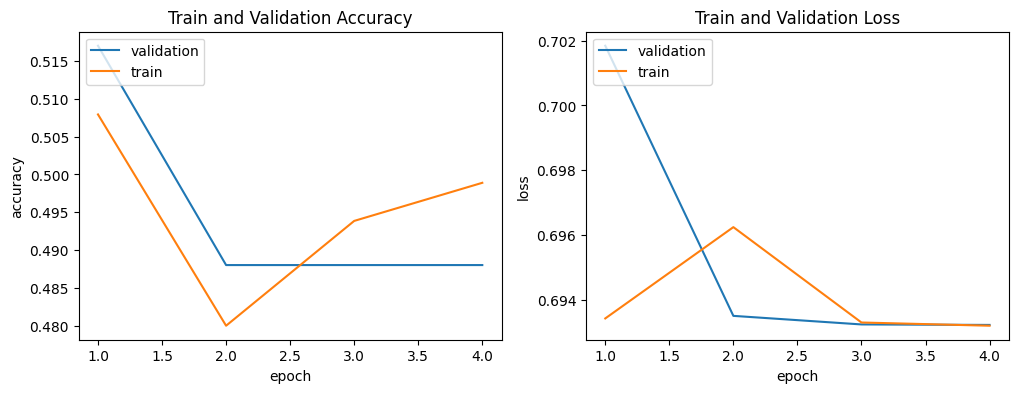

In [39]:
#plot the best model
model_history = model_histories[3]
epochs = len(model_history.history['accuracy'])
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, epochs+1), valid_accuracy) 
accuracy.plot(range(1, epochs+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, epochs+1), valid_loss)
loss.plot(range(1, epochs+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()

In [40]:
def plot_training_history(model_histories):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for model_history in model_histories:
        ax[0].plot(model_history.history['loss'], label='training loss')
        ax[0].plot(model_history.history['val_loss'], label='validation loss')
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        ax[1].plot(model_history.history['accuracy'], label='training accuracy')
        ax[1].plot(model_history.history['val_accuracy'], label='validation accuracy')
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
    plt.show()

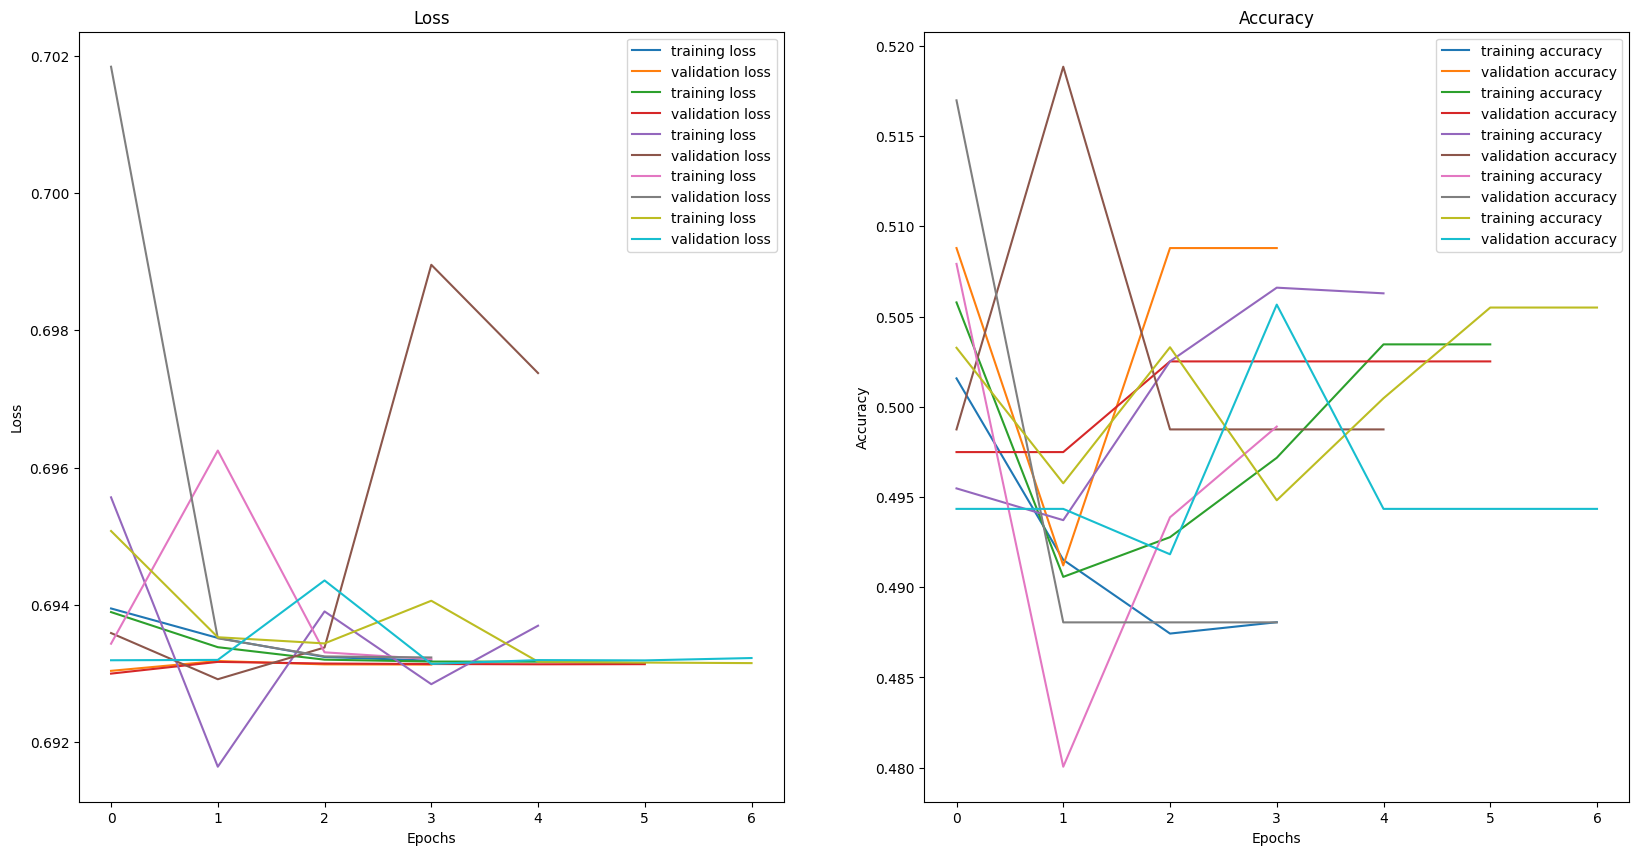

In [41]:
plot_training_history(model_histories)

In [42]:
test_images = []
test_labels = []
for images, labels in test_ds.as_numpy_iterator():
    test_images.extend(images)
    test_labels.extend(labels)
test_images = np.array(test_images).astype('float32')/255
test_labels = np.array(test_labels).astype('int')

2024-03-19 11:17:02.030198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
model = (model_histories[2].model)
model.evaluate(test_images, test_labels)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5071 - loss: 0.6907


[0.6915011405944824, 0.526627242565155]